In [47]:
import os
import torch
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from data.images import PtbXlDataModule
from models.images import ImageClassifier

In [2]:
train_dir = os.path.join('dataset/cinc2017/', 'processed/train')
train_label = os.path.join('dataset/cinc2017/', 'processed/y_train.csv')
val_dir = os.path.join('dataset/cinc2017/', 'processed/val')
val_label = os.path.join('dataset/cinc2017/', 'processed/y_val.csv')
# test_dir = 'dataset/ptb-xl/processed/test'
# test_label = 'dataset/ptb-xl/processed/y_test.csv'

datamodule = PtbXlDataModule(
    train_dir=train_dir,
    train_label=train_label,
    val_dir=val_dir,
    val_label=val_label,
    # test_dir=test_dir,
    # test_label=test_label,
    batch_size=64
)

classes = datamodule.train_dataset.labels.columns
saved_model = ImageClassifier.load_from_checkpoint(
    'logs/ckpt/epoch=19-val_loss=0.41-val_f1=0.79.ckpt',
    classes=classes,
    barebone='resnet50', # 'vit_b_16'
    learning_rate=5e-4,
    loss_type='bce')

In [3]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

100%|██████████| 64/64 [00:03<00:00, 16.75it/s]


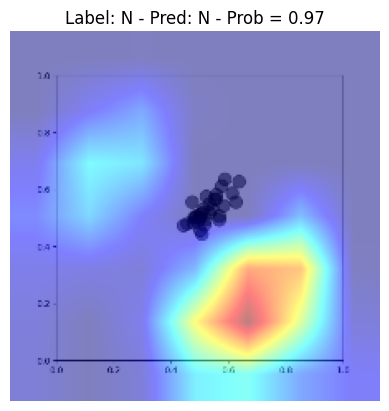

In [59]:
CAM = AblationCAM

output_dir = os.path.join('./logs', 'cam_output', CAM.__name__)
os.makedirs(output_dir, exist_ok=True)

model = saved_model.network
target_layers = [model.layer4[-1]]
cam = CAM(model=model, target_layers=target_layers, use_cuda=True)

for idx, data in enumerate(iter(datamodule.val_dataset)):
    input_tensor = data['image'].unsqueeze(dim=0)
    label = data['label'].cpu().numpy()
    label_id = label.argmax()

    logits = model(input_tensor.to('cuda'))
    probs = torch.sigmoid(logits)
    pred_id = probs.argmax().item()
    prob = probs.max().item()

    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    rgb_img = input_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.title(f'Label: {classes[label_id]} - Pred: {classes[pred_id]} - Prob = {prob:.2f}')
    plt.savefig(os.path.join(output_dir, f"{idx:03d}.png"))

0

In [29]:
label_N = []
for data in iter(datamodule.val_dataset):
    if data['label'][0] == 1:
        label_N.append(data['image'])

In [4]:
label_A = []
for data in iter(datamodule.val_dataset):
    if data['label'][1] == 1:
        label_A.append(data['image'])

In [35]:
label_N_vis = []
for input_tensor in tqdm(label_N[:20]):
    model = saved_model.network
    target_layers = [model.layer4[-1]]
    input_tensor = input_tensor.unsqueeze(0)

    
    logits

    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    rgb_img = input_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    label_N_vis.append(visualization)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:03<00:00, 16.67it/s]


In [36]:
label_A_vis = []
for input_tensor in tqdm(label_A[:20]):
    model = saved_model.network
    target_layers = [model.layer4[-1]]
    input_tensor = input_tensor.unsqueeze(0)

    cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    targets = [ClassifierOutputTarget(1)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    rgb_img = input_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    label_A_vis.append(visualization)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:03<00:00, 16.67it/s]


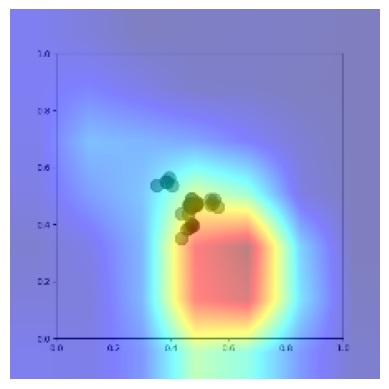

In [37]:
# plt.imshow(label_N_vis[2])
# plt.axis('off');

In [46]:
# plt.imshow(label_A_vis[7])
# plt.axis('off');